MNSIT(Modified national institute of standards and technology) 'is the de facto "hello world" dataset of computer vision.
In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We've curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare

- Take an image of a handwritten single digit, and determine what that digit is, for every in the test set, you should predict the correct label.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [24]:
class CustomMNISTDataset(Dataset):
  def __init__(self, csv_file, transform=None, is_test = False):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len (self.data_frame)

  def __getitem__(self, index):
    item = self.data_frame.iloc[index]

    if self.is_test:
      image = item.values.reshape(28, 28).astype(np.uint8)
      label = None

    else:
      image = item[1:].values.reshape(28, 28).astype(np.uint8)
      label = item.iloc[0]

    image = transforms.ToPILImage()(image)

    if self.transform is not None:
      image = self.transform(image)

    if self.is_test:
      return image

    else:
      return image, label # Modified line: return both image and label

In [25]:
#build our transform
transform= transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])
"""this is a common practice in computer vision to augment
the data and improve model performance
- random rotation, conversor to a pytorch tensor and normalization"""

'this is a common practice in computer vision to augment\nthe data and improve model performance\n- random rotation, conversor to a pytorch tensor and normalization'

In [26]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#set up out train and test data sets
train_dataset = CustomMNISTDataset(csv_file = '/content/drive/My Drive/digit-recognizer/train.csv', transform=transform, is_test = False)#set up out train and test data sets
test_dataset = CustomMNISTDataset(csv_file = '/content/drive/My Drive/digit-recognizer/test.csv', transform=transform, is_test = True)

In [28]:
print('Train Size: ' +str(len(train_dataset)) + ', Test Size:' + str(len(test_dataset)))

Train Size: 42000, Test Size:28000


In [29]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [30]:
#build our data loader
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size= batch_size, shuffle=False, num_workers=2)

Input size: torch.Size([64, 1, 28, 28])


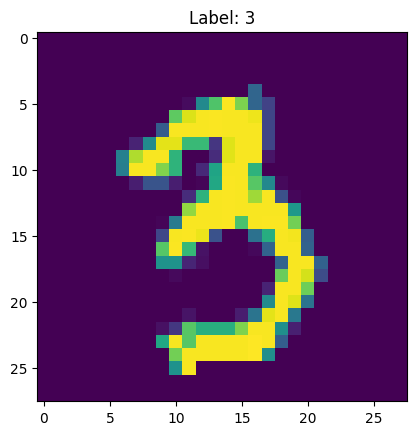

In [32]:
for example_data, example_labels in train_loader:
  example_image = example_data[0]
  print("Input size:", example_data.size())


  example_image_numpy = example_image.permute(1, 2, 0).numpy()

  plt.imshow(example_image_numpy)
  plt.title(f"Label: {example_labels[0]}")
  plt.show()

  break

In [35]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128 * 7 * 7, 128)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 20)
    self.fc3 = nn.Linear(20, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.pool(x)

    x_size = x.size(1) * x.size(2) * x.size(3)

    x= x.view(-1, x_size)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [36]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer= optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

In [38]:
#build our training loop
num_epochs = 100
running_loss = 0.0

for epoch in range(num_epochs):
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs.float())
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 100 == 99:
      print(f"[{epoch + 1}, {i + 1}] Loss: {running_loss / 100:.3f}")
      running_loss = 0.0

print("Training finished")

[1, 100] Loss: 2.303
[1, 200] Loss: 2.285
[1, 300] Loss: 2.249
[1, 400] Loss: 2.132
[1, 500] Loss: 1.549
[1, 600] Loss: 0.750
[2, 100] Loss: 0.785
[2, 200] Loss: 0.419
[2, 300] Loss: 0.350
[2, 400] Loss: 0.365
[2, 500] Loss: 0.317
[2, 600] Loss: 0.294
[3, 100] Loss: 0.435
[3, 200] Loss: 0.250
[3, 300] Loss: 0.229
[3, 400] Loss: 0.223
[3, 500] Loss: 0.214
[3, 600] Loss: 0.188
[4, 100] Loss: 0.278
[4, 200] Loss: 0.174
[4, 300] Loss: 0.154
[4, 400] Loss: 0.157
[4, 500] Loss: 0.142
[4, 600] Loss: 0.141
[5, 100] Loss: 0.205
[5, 200] Loss: 0.123
[5, 300] Loss: 0.126
[5, 400] Loss: 0.117
[5, 500] Loss: 0.119
[5, 600] Loss: 0.126
[6, 100] Loss: 0.168
[6, 200] Loss: 0.103
[6, 300] Loss: 0.096
[6, 400] Loss: 0.104
[6, 500] Loss: 0.102
[6, 600] Loss: 0.094
[7, 100] Loss: 0.126
[7, 200] Loss: 0.094
[7, 300] Loss: 0.098
[7, 400] Loss: 0.084
[7, 500] Loss: 0.091
[7, 600] Loss: 0.087
[8, 100] Loss: 0.120
[8, 200] Loss: 0.087
[8, 300] Loss: 0.086
[8, 400] Loss: 0.087
[8, 500] Loss: 0.085
[8, 600] Loss

In [39]:
#build out our file for submission
model.eval()
predictions = []

with torch.no_grad():
  for data in test_loader:
    data = data.to(device)

    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),
    "Label": predictions
})

submission.to_csv('predictions1231final.csv', index=False)


In [40]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
